## Marker-based metrics
- MECR (mutually-exclusive co-expression rate)
- positive marker F1 score

TODO:
- MECR score: exclude cell types that don't have markers! 
- fix marker dict!
- currently no unique markers for vascular subtypes. Makes no sense to caluclate these scores for them ATM!

## Compute MECR score

In [1]:
from cellseg_benchmark.metrics import (
    compute_MECR_score,
    compute_metric_for_all_methods,
)

compute_metric_for_all_methods(
    compute_MECR_score,
    results_name="marker_gene_metrics/MECR_score_all.csv",
    cohort="aging",
    subset_vascular_celltypes=False,
    overwrite=False,
)

compute_metric_for_all_methods(
    compute_MECR_score,
    results_name="marker_gene_metrics/MECR_score_vascular_celltypes.csv",
    cohort="aging",
    subset_vascular_celltypes=True,
    overwrite=False,
)

overwriting existing results for compute_MECR_score
Running compute_MECR_score for Cellpose_1_DAPI_PolyT


## Plot MECR score

/dss/dsshome1/0E/ra64luf2/projects/cellsegmentation_benchmark/st-bsb/cellseg_benchmark/metrics/marker_gene_based.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/dss/dsshome1/0E/ra64luf2/projects/cellsegmentation_benchmark/st-bsb/cellseg_benchmark/metrics/marker_gene_based.py:159: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


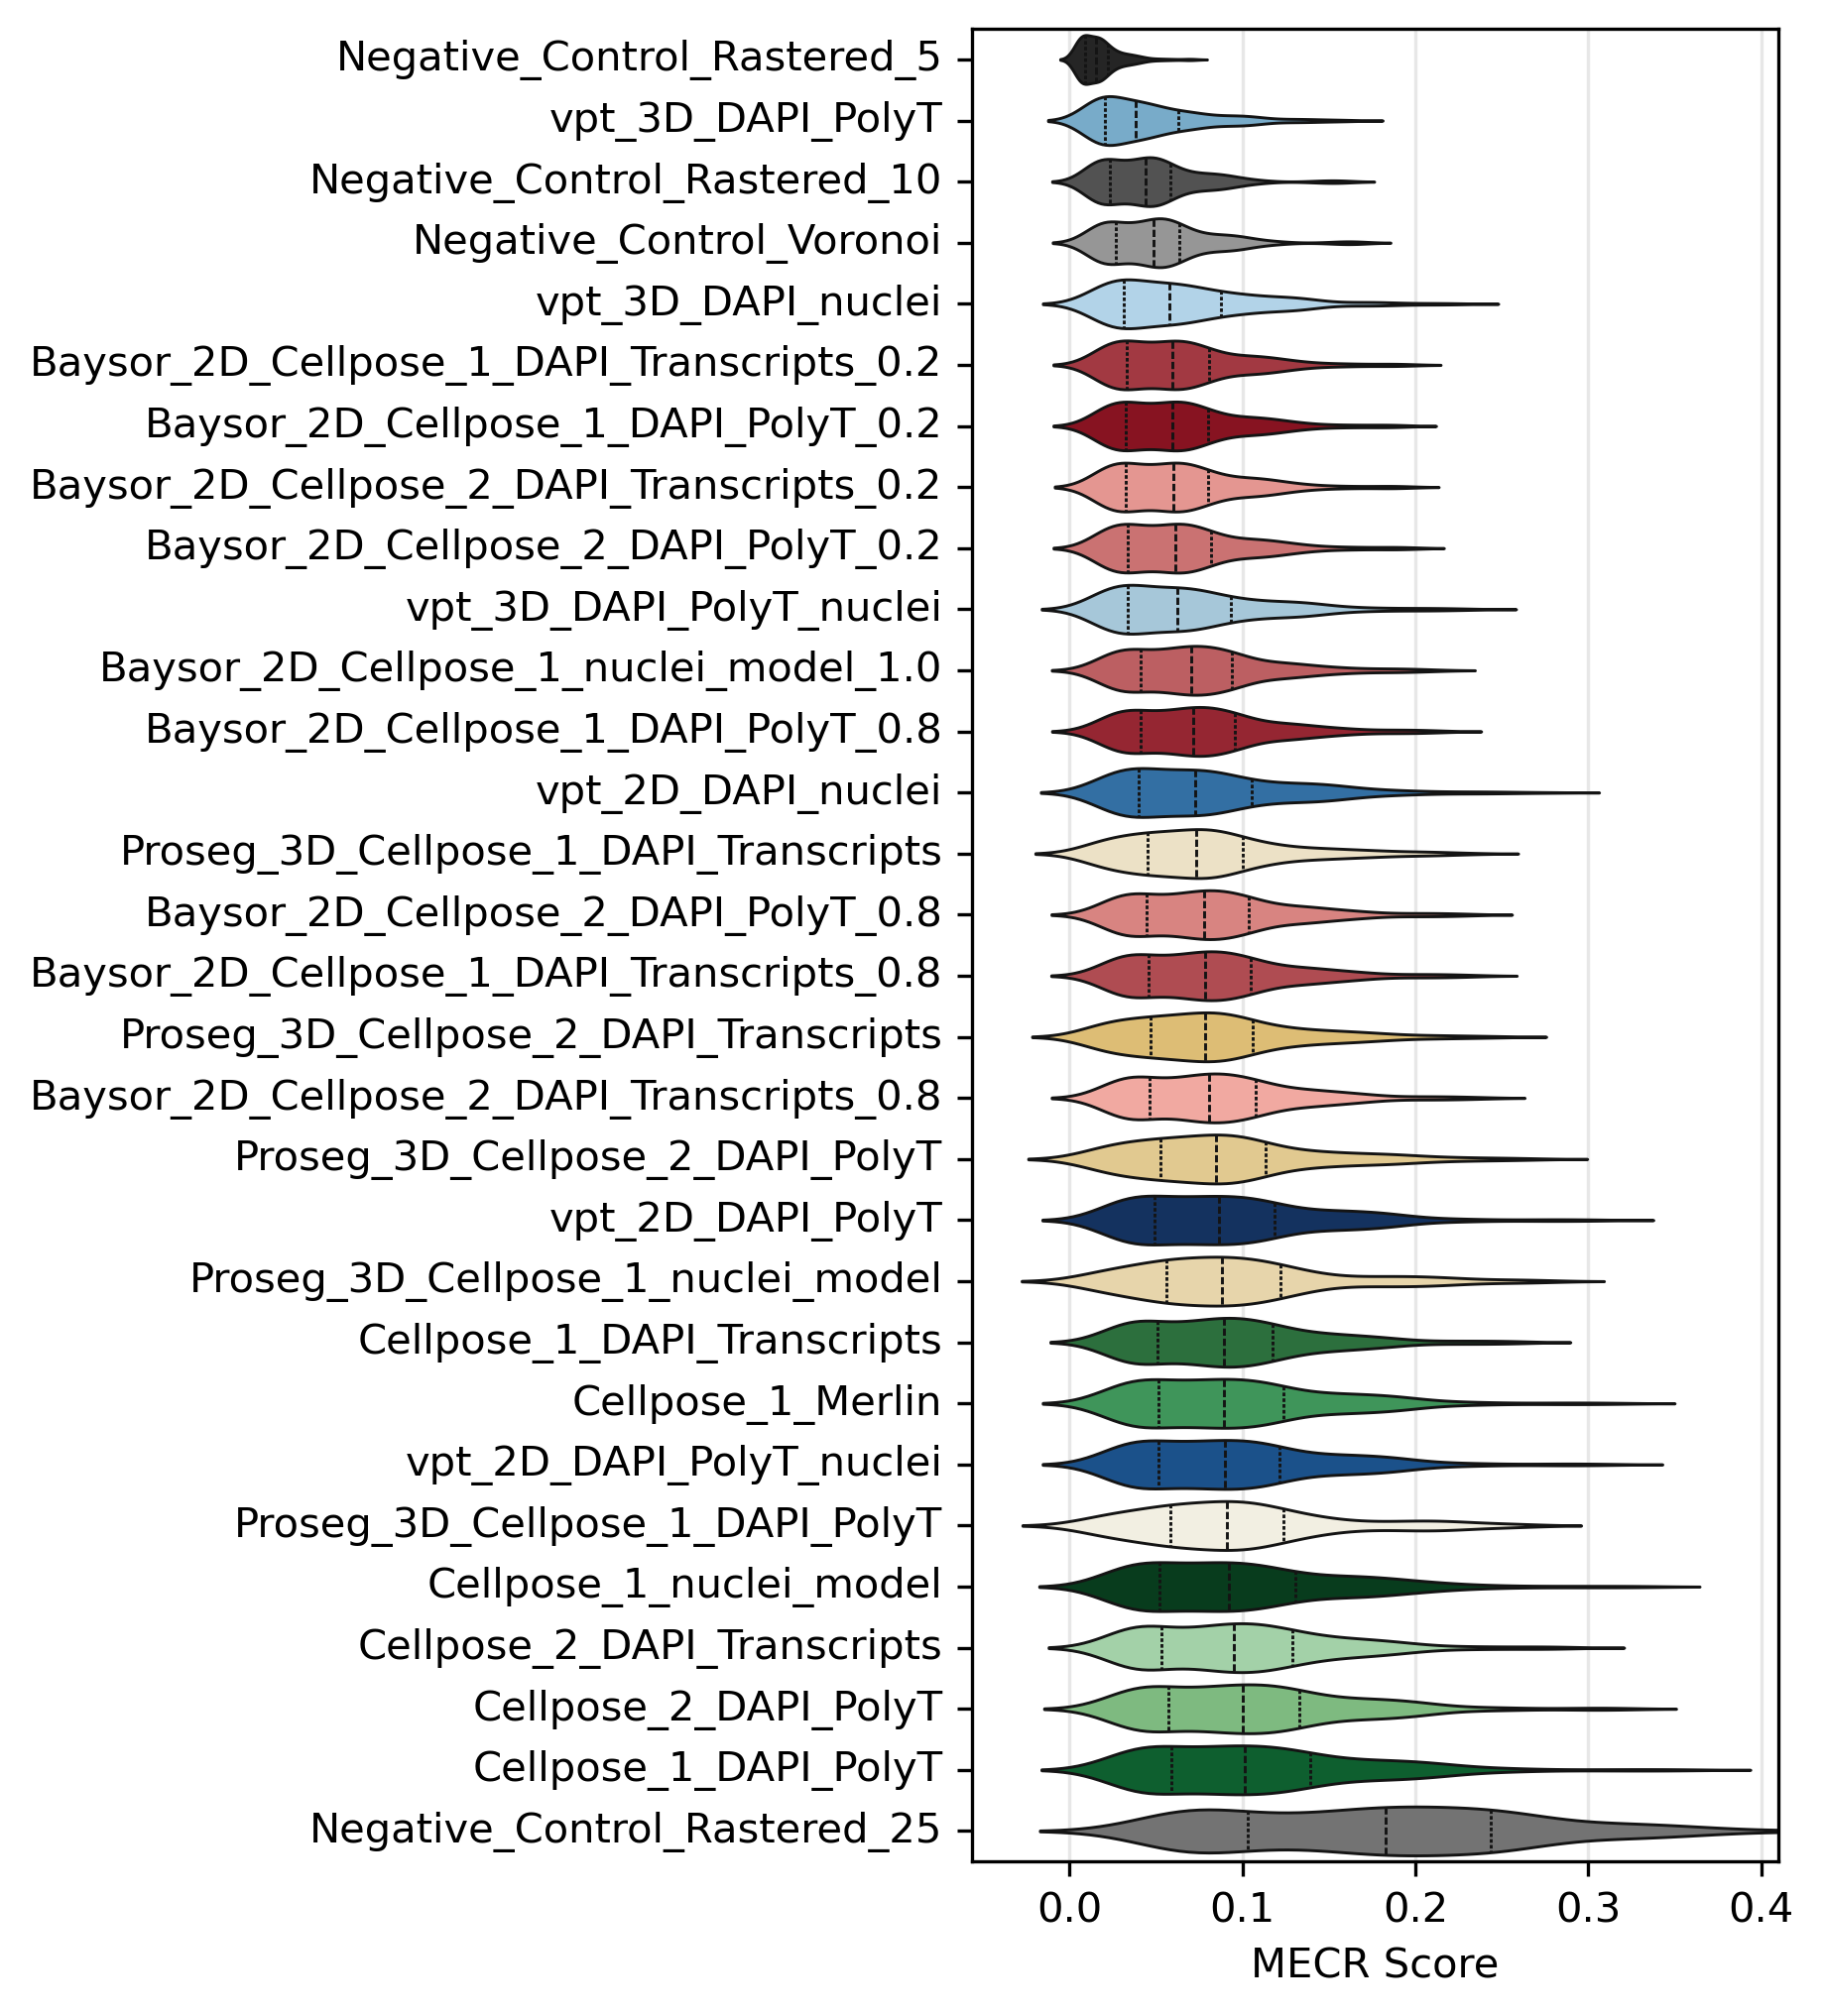

/dss/dsshome1/0E/ra64luf2/projects/cellsegmentation_benchmark/st-bsb/cellseg_benchmark/metrics/marker_gene_based.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/dss/dsshome1/0E/ra64luf2/projects/cellsegmentation_benchmark/st-bsb/cellseg_benchmark/metrics/marker_gene_based.py:159: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


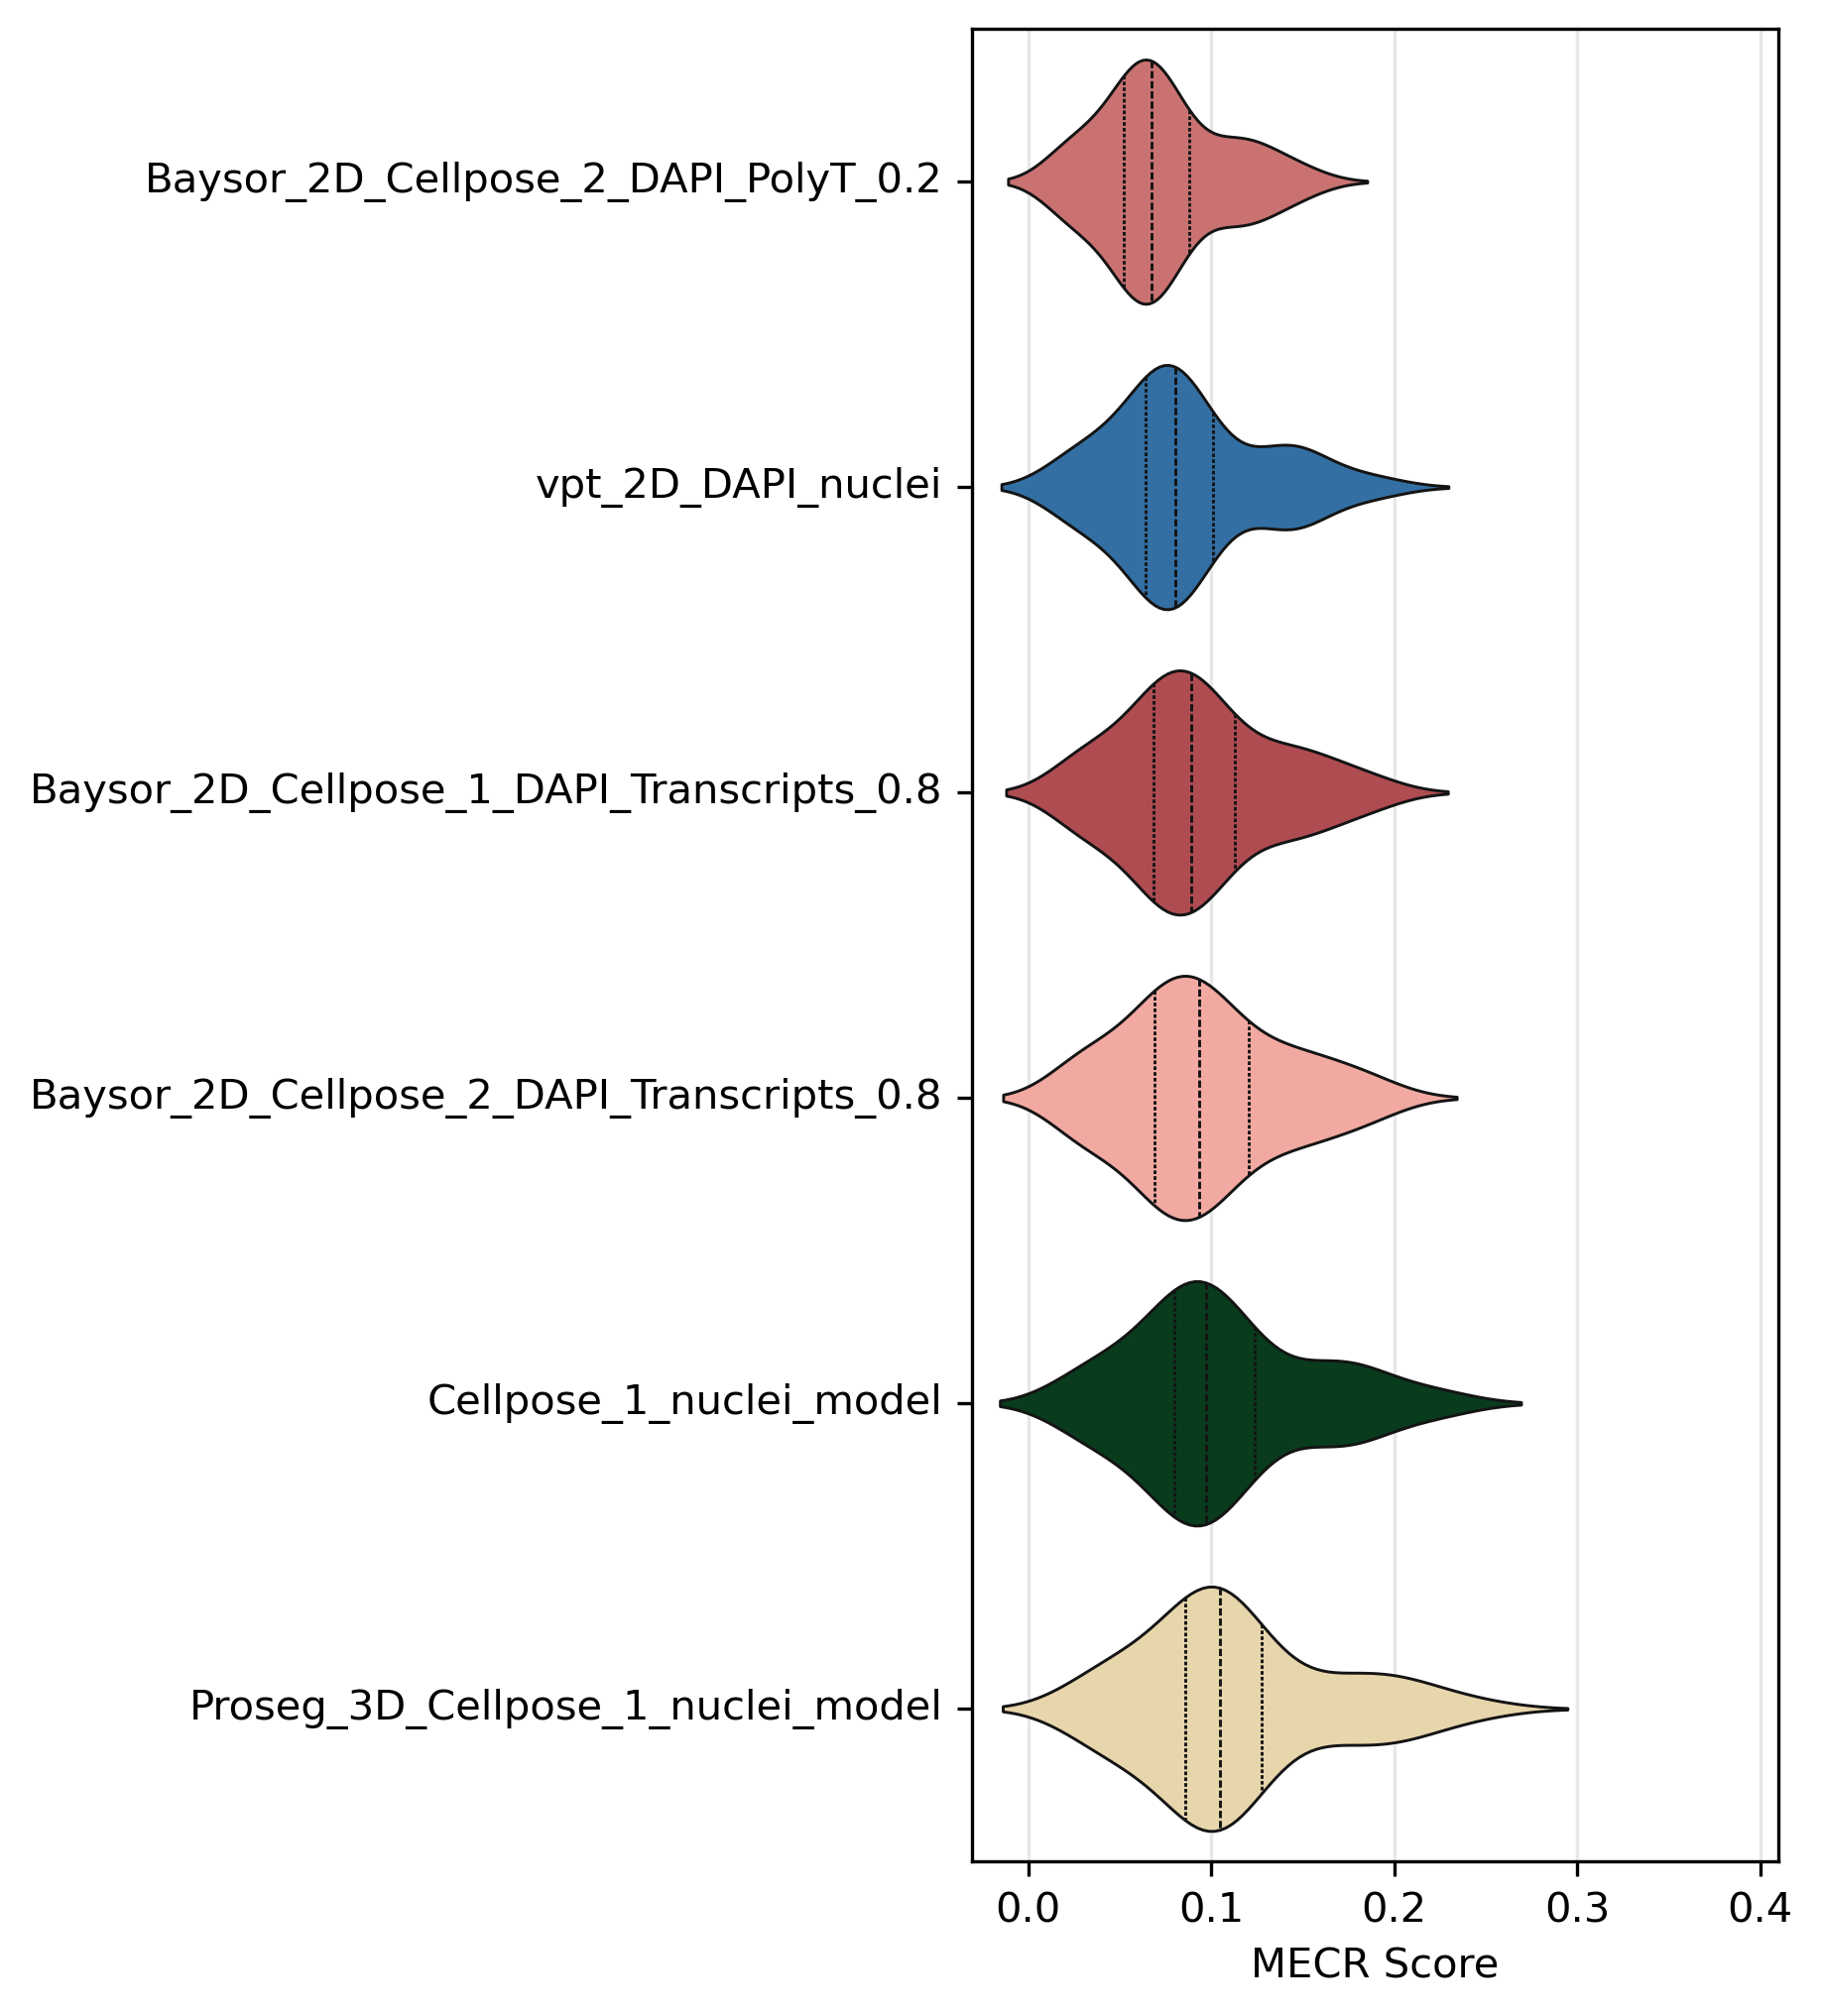

In [1]:
from cellseg_benchmark.metrics import plot_MECR_score

plot_MECR_score("aging", "all", show=True)
plot_MECR_score("aging", "vascular_celltypes", show=True)

## Compute Marker F1 score

In [ ]:
from cellseg_benchmark.metrics import (
    compute_marker_F1_score,
    compute_metric_for_all_methods,
)

compute_metric_for_all_methods(
    compute_marker_F1_score,
    results_name="marker_gene_metrics/marker_f1_score_cell_type_revised.csv",
    cohort="aging",
    celltype_name="cell_type_revised",
    overwrite=False,
)

1/30 Running compute_marker_F1_score for Proseg_3D_Cellpose_1_nuclei_model


## Plot marker F1 score

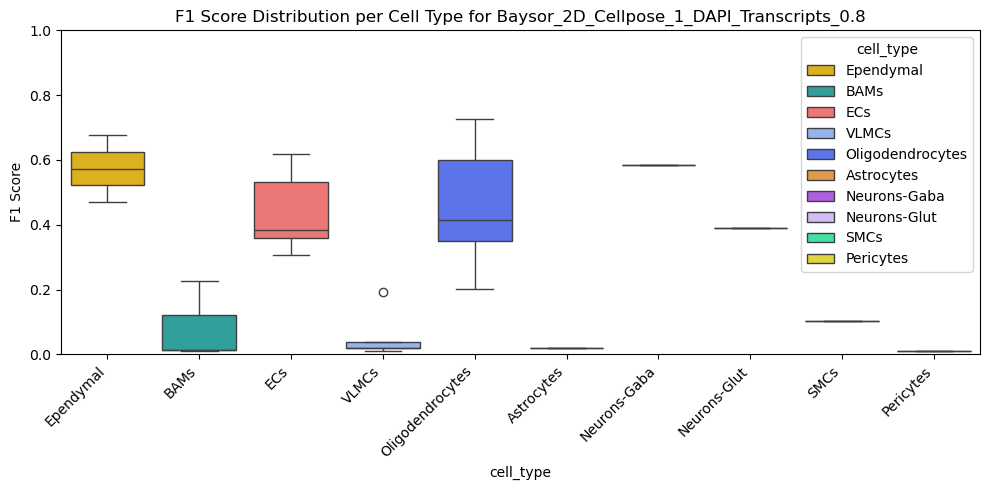

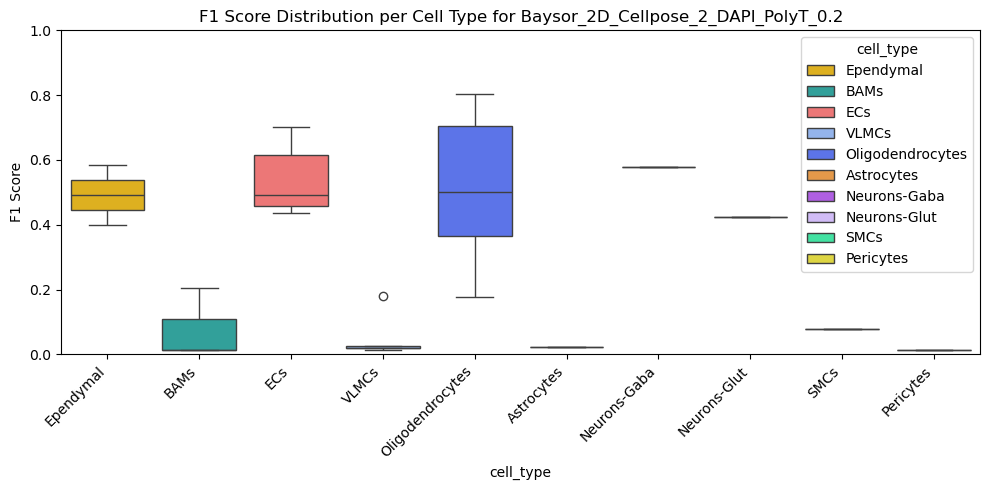

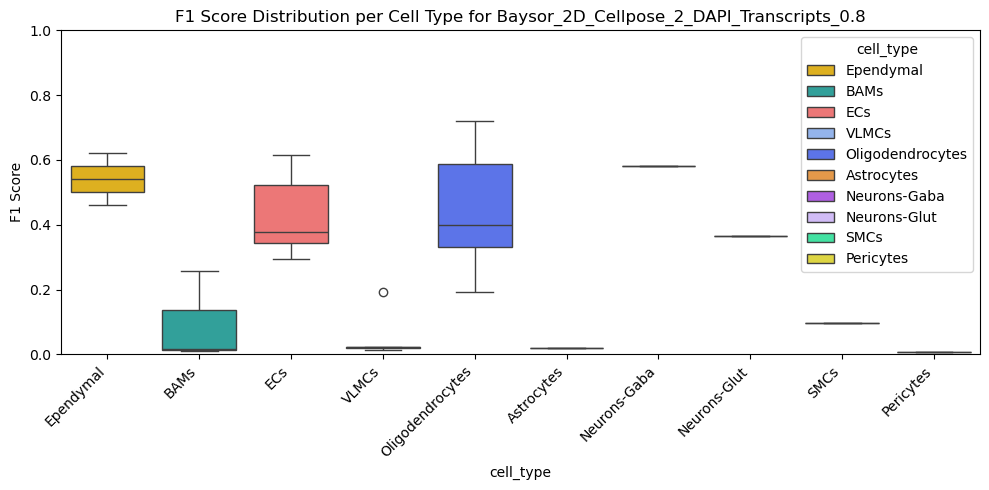

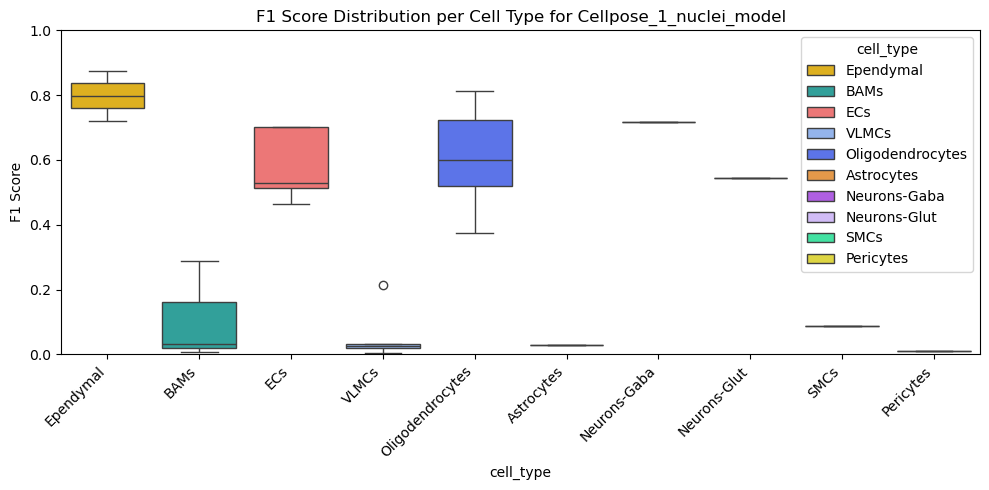

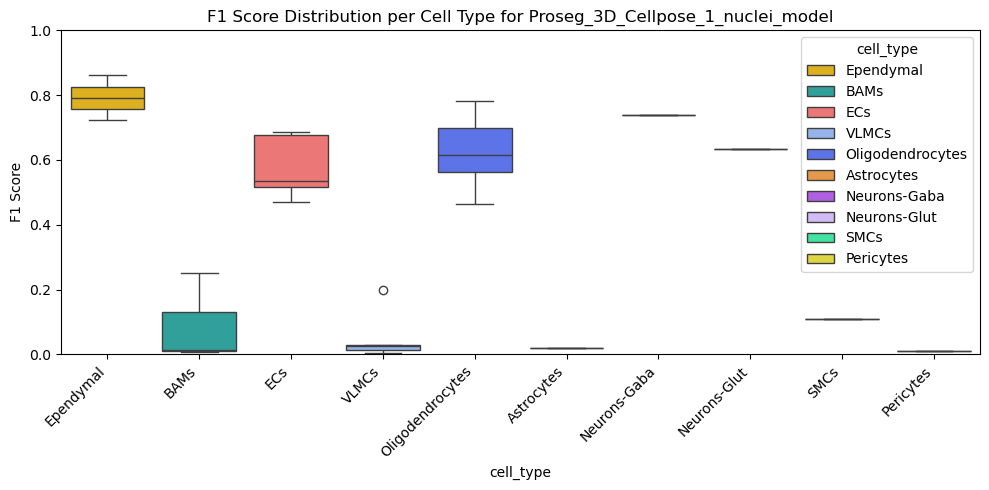

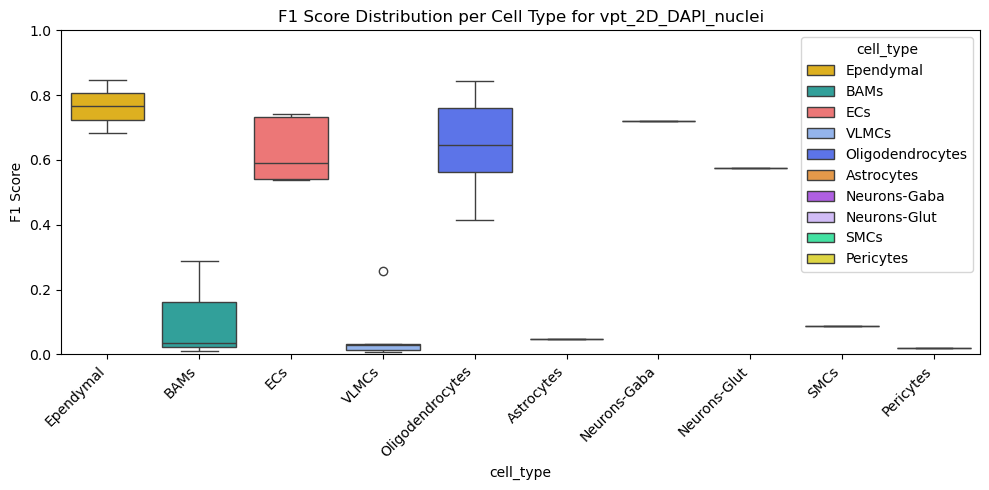

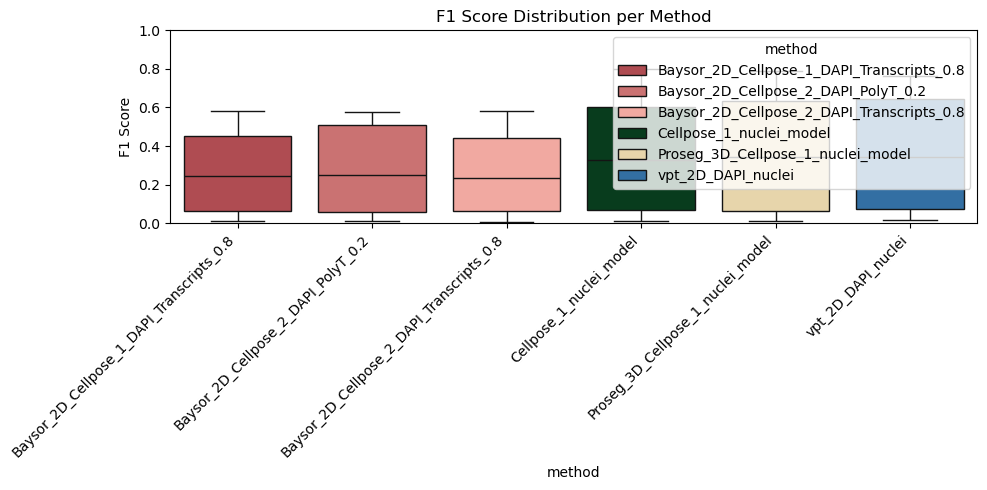

In [1]:
from cellseg_benchmark.metrics import plot_marker_F1_score

plot_marker_F1_score(cohort="aging", results_suffix="cell_type_revised", show=True)

## Compute negative marker purity


In [ ]:
from cellseg_benchmark.metrics import (
    compute_metric_for_all_methods,
    compute_negative_marker_purity,
    get_negative_markers,
)

neg_marker_mask, ratio_celltype = get_negative_markers("aging", vascular_subset=False)
compute_metric_for_all_methods(
    compute_negative_marker_purity,
    results_name="marker_gene_metrics/negative_marker_purity_all.csv",
    neg_marker_mask_sc=neg_marker_mask,
    ratio_celltype_sc=ratio_celltype,
    overwrite=False,
)

neg_marker_mask, ratio_celltype = get_negative_markers("aging", vascular_subset=True)
compute_metric_for_all_methods(
    compute_negative_marker_purity,
    results_name="marker_gene_metrics/negative_marker_purity_vascular_celltypes.csv",
    neg_marker_mask_sc=neg_marker_mask,
    ratio_celltype_sc=ratio_celltype,
    overwrite=False,
)

## Plot negative marker purity